# MPC Example Using Scipy optimization
reference: 

https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html

To Do:

Create NL model; create function to simulate response to input; 


In [3]:
import numpy as np
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import LinearConstraint
%matplotlib inline

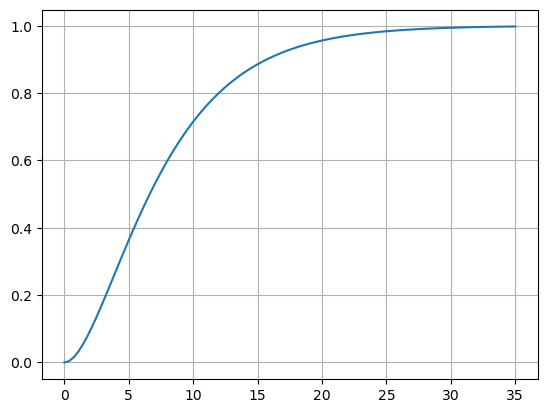

In [4]:
G = scipy.signal.lti([1], [15, 8, 1])
plt.plot(*G.step());
plt.grid()

In [5]:
M = 10  # Control horizon
P = 100  # Prediction horizon
DeltaT = .1  # Sampling rate
tcontinuous = np.linspace(0, P*DeltaT, 1000)  # some closely spaced time points
tpredict = np.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon

# first order reference trajectory
tau_c = 1
r = 1 - np.exp(-tpredict/tau_c)  

u = np.ones(M)  # initial guess for optimized control

x0 = np.zeros(G.to_ss().A.shape[0])  # Initial system state

In [6]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return np.concatenate([u, np.repeat(u[-1], P-M)])

In [7]:
def prediction(u, t=tpredict, x0=x0):
    """Predict the effect of an input signal"""
    t, y, x = scipy.signal.lsim(G, u, t, X0=x0, interp=False)
    return y

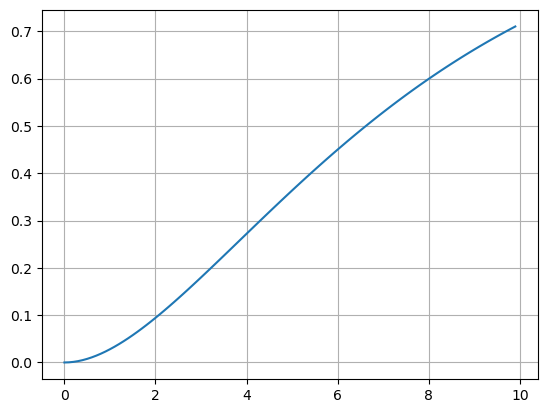

In [8]:
plt.plot(tpredict, prediction(extend(u)));
plt.grid()

In [9]:
'''
def objective(u, x0=x0):
    """Calculate the sum of the square error for the cotnrol problem"""
    y = prediction(extend(u))
    return sum((r - y)**2)
'''
def objective(u, x0=x0):
    y = prediction(extend(u))
    umag = np.abs(u)
    constraintpenalty = sum(umag[umag > 2])
    movepenalty = sum(np.abs(np.diff(u)))
    strongfinish = np.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0.0*constraintpenalty + 1.0*movepenalty + 0*strongfinish

In [10]:
objective(u)

32.94191787624925

In [11]:
result = scipy.optimize.minimize(objective, u)
uopt = result.x
result.fun

11.230528990325443

In [12]:
ucont = extend(uopt)[((tcontinuous-0.01)//DeltaT).astype(int)]


In [13]:
def plotoutput(ucont, uopt):
    plt.figure()
    plt.plot(tcontinuous, ucont)
    plt.xlim([0, DeltaT*(P+1)])
    plt.grid()
    plt.figure()
    plt.plot(tcontinuous, prediction(ucont, tcontinuous), label='Continuous response')
    plt.plot(tpredict, prediction(extend(uopt)), '-o', label='Optimized response')
    plt.plot(tpredict, r, label='Set point')
    plt.grid()
    plt.legend()

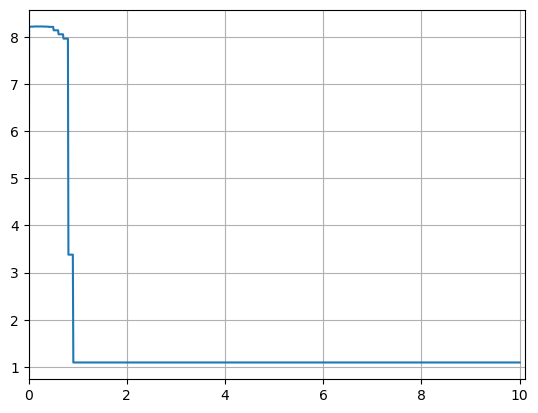

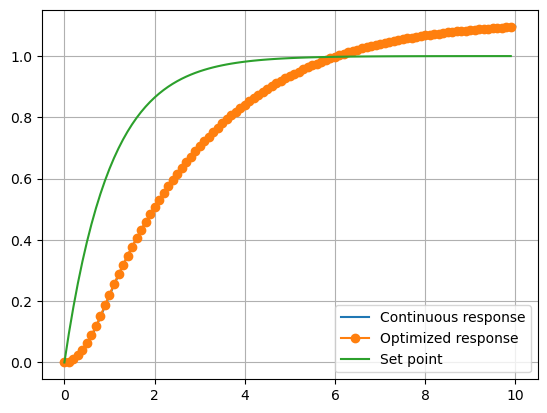

In [14]:
plotoutput(ucont, uopt)

### Simple NL MPC Model

Stable continuous nonlinear model: <br /> 
$\dot{x} = -x^{3} + u$

In discrete time using finite difference: <br /> 
$x[k+1] = x[k] - \Delta T x[k]^{3} + \Delta T u[k]$

Steady state output:  1.2485555011266727


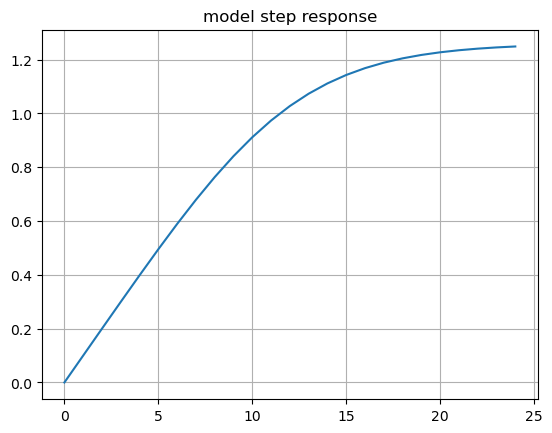

In [15]:
x = np.zeros(25)
u = 2*np.ones(25)
dt = 0.05
for k in range(len(x)-1):
    x[k+1] = x[k] -dt*x[k]**3 + dt*u[k]
    
plt.plot(x)
plt.title("model step response")
plt.grid()
print("Steady state output: ", x[-1])

In [16]:
def nl_prediction(u, dt, x0=x0):
    """Predict the effect of an input signal"""
    x = np.empty(len(u))    
    x[0] = x0
    for k in range(len(x)-1):
        x[k+1] = x[k] -dt*x[k]**3 + dt*u[k]
    
    return x

In [17]:
'''
def objective(u, x0=x0):
    """Calculate the sum of the square error for the control problem"""
    y = prediction(extend(u))
    return sum((r - y)**2)
'''
def objective(u, x0=x0):
    y = nl_prediction(extend(u), dt, x0)    
    umag = np.abs(u)
    constraintpenalty = sum(umag[umag > 2])    
    #movepenalty = sum(np.abs(np.diff(u)))
    movepenalty = sum(np.diff(u)**2)
    strongfinish = np.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0.0*constraintpenalty + 0.0*movepenalty + 0*strongfinish

In [18]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return np.concatenate([u, np.repeat(u[-1], P-M)])

In [19]:
# plot results
def plot_results(timeSamples, x, ref, u):    
    plt.figure()
    plt.plot(timeSamples, x, '-bo', label = 'Output')
    plt.plot(timeSamples, ref[:len(timeSamples)], 'r', label='Reference')
    plt.grid()
    plt.legend()    
    plt.figure()
    plt.plot(timeSamples, u, label='Control')
    plt.grid()
    plt.legend()
    plt.figure()
    plt.plot(timeSamples[0:-1], np.diff(u, axis=0), label='$\Delta$ Control')
    plt.grid()
    plt.legend()


In [20]:
M = 25
P = 50

# first order reference trajectory
tau_c = 1
tpredict = np.arange(0, P*dt, dt)   # discrete points at prediction horizon
r = 2 - 2*np.exp(-tpredict/tau_c)  
u = np.zeros(M)  # initial guess for optimized control


In [21]:
def linear_constraint_calc(M, lb, ub):
    A= -np.eye(M)+np.eye(M, k=1)
    return LinearConstraint(A, lb*np.ones((M,)), ub*np.ones((M,)))

0.10299873352050781
9.843799609803497


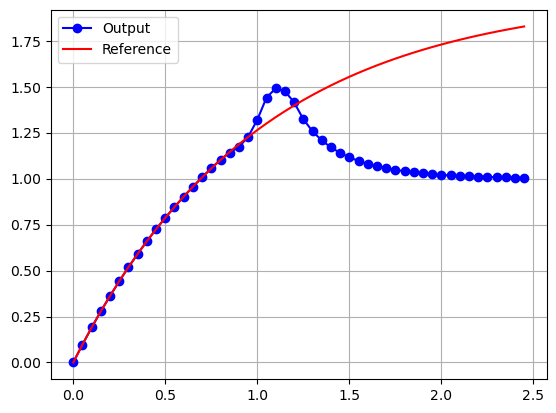

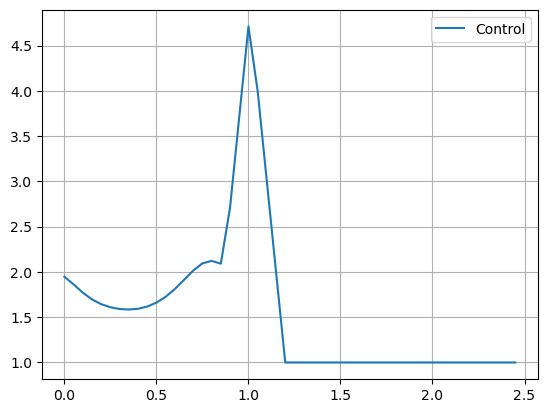

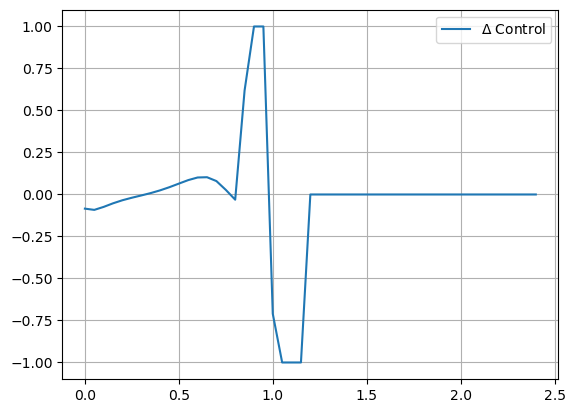

In [22]:
x0 = 0
startTime = time()
lb = -1
ub = 1
linear_constraint = linear_constraint_calc(M, lb, ub)
result = scipy.optimize.minimize(objective, u, x0, method = 'SLSQP', constraints=[linear_constraint])
#result = scipy.optimize.minimize(objective, u, x0)
print(time()-startTime)
uopt = result.x
print(result.fun)
uact = extend(uopt)
plot_results(tpredict, nl_prediction(uact, dt, x0), r, uact)

## Simulate control loop 

In [23]:
# Set initial conditions and tuning parameters
M = 75
P = 100
simTime = 50
dt = 0.1
cycles = int(simTime/dt)
x = np.zeros((cycles, 1))
uact = np.ones((cycles, 1))

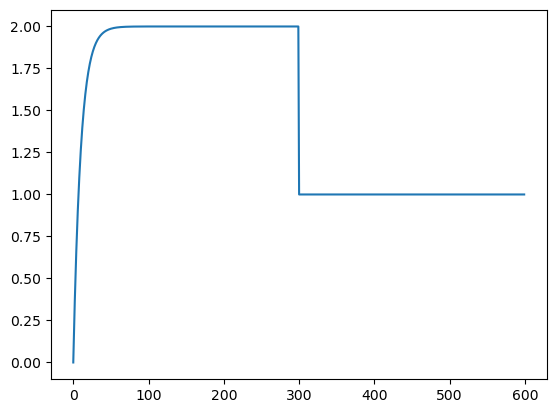

In [24]:
#set reference trajectory
tau_c = 1
t1 = np.arange(0, P*dt, dt)
ref1 = 2 - 2*np.exp(-t1/tau_c)  
ref2 = np.repeat(ref1[-1], 200)
ref3 = np.repeat(1, 300)
ref4 = np.repeat(-1, P+cycles-len(ref1)-len(ref2)-len(ref3))
ref = np.concatenate([ref1, ref2, ref3, ref4])
plt.plot(ref);

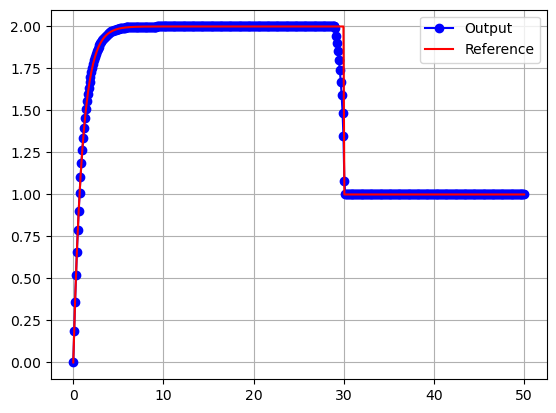

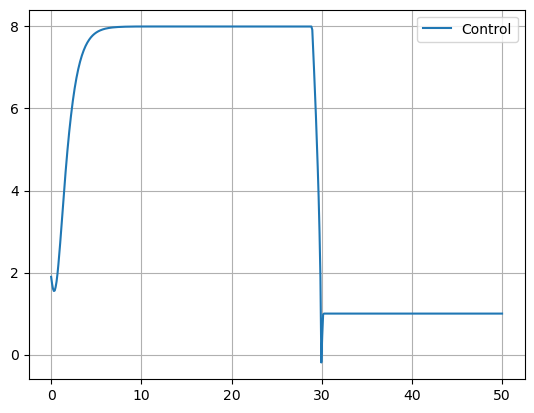

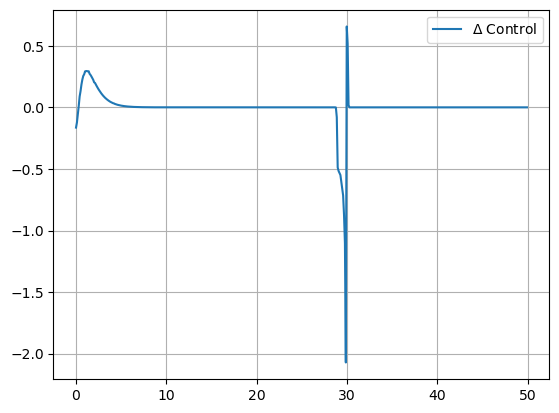

In [25]:
import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")
# simulation loop
u = np.ones(M)  # optimization initial guess

ub = 0.5
lb = -0.5 
linear_constraint = linear_constraint_calc(M, lb, ub)
for k in range(cycles-1):
    r = ref[k:k+P]
    x0 = x[k]
    # call optimization    
    #result = scipy.optimize.minimize(objective, u, x0)
    result = scipy.optimize.minimize(objective, u, x0, method = 'SLSQP', constraints=[linear_constraint])
    uopt = result.x    
    uact[k] = uopt[0]
    
    # simulate plant with control input
    x[k+1] = x[k] -dt*x[k]**3 + dt*uact[k]
    
    u = uact[k]*np.ones(M)  # update optimization guess for the next iteration
    
    if np.abs(x[k]) > 1E6:
        break
        
# plot results
timeSamples = np.linspace(0, simTime, len(x))
plot_results(timeSamples, x, ref, uact)

### NL TCLab Model


In [26]:
Ta = 23.0+273.15     # K
mass = 4.0/1000.0    # kg
Cp = 0.5*1000.0      # J/kg-K    
A = 10.0/100.0**2    # Area not between heaters in m^2
As = 2.0/100.0**2    # Area between heaters in m^2
eps = 0.9            # Emissivity
sigma = 5.67e-8            # Stefan-Boltzmann
tau = 50
U = 10
alpha1 = 0.01
alpha2 = 0.0075

In [284]:
# Prediction function
# Need to vectorize this for loop

def Tc_prediction(u, dt, x0 = x0):
    #Q1 = u[:, 0]
    #Q2 = u[:, 1]

    inputLen = int(len(u)/2)

    if inputLen ==1:
        TC1 = np.empty(2)
        TC2 = np.empty(2)     
        TH1 = np.empty(2)
        TH2 = np.empty(2) 
    else:
        TC1 = np.empty(inputLen)
        TC2 = np.empty(inputLen)     
        TH1 = np.empty(inputLen)
        TH2 = np.empty(inputLen)                
        
    TC1[0] = x0[0]
    TC2[0] = x0[1]
    TH1[0] = x0[0]
    TH2[0] = x0[1]
    loops = max(1, inputLen-1)
    for k in range(loops):
        # Heater temperatures
        T1i = TH1[k]+273.15
        T2i = TH2[k]+273.15
        # Heat transfer between two heaters
        Q_C12 = U*As*(T2i-T1i) # Convective
        Q_R12 = eps*sigma*As*(T2i**4-T1i**4) # Radiative
        
        TH1[k+1] = TH1[k] + dt*(1.0/(mass*Cp))*(U*A*(Ta-T1i) \
                            + eps * sigma * A * (Ta**4 - T1i**4) \
                            + Q_C12 + Q_R12 \
                            + alpha1*u[2*k])
        
        TH2[k+1] = TH2[k] + dt*(1.0/(mass*Cp))*(U*A*(Ta-T2i) \
                            + eps * sigma * A * (Ta**4 - T2i**4) \
                            - Q_C12 - Q_R12 \
                            + alpha2*u[2*k+1])
        
        TC1[k+1] = TC1[k] + dt*(-TC1[k] + TH1[k])/tau
        TC2[k+1] = TC2[k] + dt*(-TC2[k] + TH2[k])/tau    
    return TC1, TC2

In [274]:
for k in range(1):
    print(k)

0


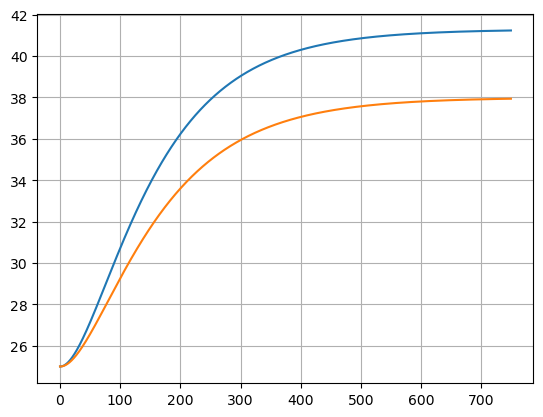

In [149]:
dt = 1
cycles = 1000
P = 750
Q = 30*np.ones((2*P, 1))

TC0 = 25*np.ones((2,1))
TC1_, TC2_= Tc_prediction(Q, dt, TC0)
plt.plot(TC1_);
plt.plot(TC2_);
plt.grid()

In [159]:
# Extend function

def Tc_extend(u):
    """We optimise the first M values of u but we need P values for prediction"""    
    uExt = np.kron(np.ones(P-M), u[-2:])
    #out = np.concatenate([u, np.tile(u[-1,:], (P-M,1))])
    return np.concatenate((u, uExt), axis=0)

In [293]:
# Objective Function
'''
def objective(u, x0=x0):
    y = nl_prediction(extend(u), dt, x0)    
    umag = np.abs(u)
    constraintpenalty = sum(umag[umag > 2])    
    #movepenalty = sum(np.abs(np.diff(u)))
    movepenalty = sum(np.diff(u)**2)
    strongfinish = np.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0.0*constraintpenalty + 0.0*movepenalty + 0*strongfinish
'''

P = 500
M = 250 

q1 = 2
q2 = 3

r1 = 0.1
r2 = 1

ref1 = 35*np.ones((P,1))
ref2 = 30*np.ones((P,1))

def Tc_objective(u, x0=x0):
    y1, y2 = Tc_prediction(Tc_extend(u), dt, x0)    
    
    return q1*np.sum((ref1-y1)**2) + q2*np.sum((ref2-y2)**2) + r1*np.sum(u**2) 
    #J = np.transpose(ref1-y1).dot(Q1).dot(ref1-y1) + np.transpose(ref2-y2).dot(Q2).dot(ref2-y2)
    #return J[0]
 

Q = 30*np.ones((2*M))
x0 = TC0
result = Tc_objective(Q, x0)
result

233743268.8163877

In [222]:
result = scipy.optimize.minimize(Tc_objective, Q, x0, method="SLSQP")
uopt = result.x


C:\Users\jeffa\AppData\Local\Temp\ipykernel_35104\2506806992.py:24: RuntimeWarning: overflow encountered in double_scalars
  Q_R12 = eps*sigma*As*(T2i**4-T1i**4) # Radiative
C:\Users\jeffa\AppData\Local\Temp\ipykernel_35104\2506806992.py:24: RuntimeWarning: invalid value encountered in double_scalars
  Q_R12 = eps*sigma*As*(T2i**4-T1i**4) # Radiative
C:\Users\jeffa\AppData\Local\Temp\ipykernel_35104\2506806992.py:32: RuntimeWarning: overflow encountered in double_scalars
  + eps * sigma * A * (Ta**4 - T1i**4) \
C:\Users\jeffa\AppData\Local\Temp\ipykernel_35104\2506806992.py:37: RuntimeWarning: overflow encountered in double_scalars
  + eps * sigma * A * (Ta**4 - T2i**4) \
C:\Users\jeffa\AppData\Local\Temp\ipykernel_35104\514492677.py:28: RuntimeWarning: overflow encountered in square
  return q1*np.sum((ref1-y1)**2) + q2*np.sum((ref2-y2)**2) + r1*np.sum(u**2)


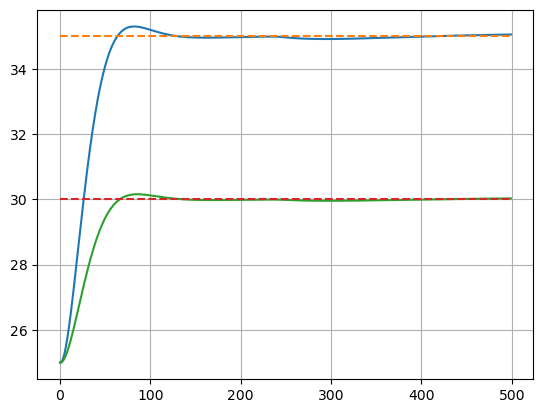

In [223]:
tc1, tc2 = Tc_prediction(Tc_extend(uopt), dt, TC0)
plt.plot(tc1)
plt.plot(ref1, '--')
plt.plot(tc2)
plt.plot(ref2, '--')
plt.grid()


In [300]:
# need state feedback (TH1 and TH2) to make this work.  Vectorize TC prediction function.   

M = 75
P = 100
simTime = 200
dt = 1
cycles = int(simTime/dt)

TC1 = 20*np.ones((cycles, 1))
TC2 = 20*np.ones((cycles, 1))
u1act = 30*np.ones((cycles, 1))
u2act = 30*np.ones((cycles, 1))

#set reference trajectory
ref1Vec = 38*np.ones((cycles+P))
ref2Vec = 33*np.ones((cycles+P))
u = 30*np.ones((2*M))

for k in range(cycles-1):
    ref1 = ref1Vec[k:k+P]
    ref2 = ref2Vec[k:k+P]
    x0 = np.array([[TC1[k]], [TC2[k]]])
    # call optimization    
    result = scipy.optimize.minimize(Tc_objective, u, x0, method = 'SLSQP')
    uopt = result.x    
    uact = uopt[:2]    
    # simulate plant with control input
    TC1_, TC2_ = Tc_prediction(uact, dt, x0)
    TC1[k+1] = TC1_[-1]
    TC2[k+1] = TC2_[-1]
    # update optimization guess for the next iteration
    u = np.kron(np.ones(M), uact[:2])
    
    
        
# plot results
timeSamples = np.linspace(0, simTime, len(x))


NameError: name 'tC2' is not defined

In [304]:
print(uopt)
print(uact)
print(Tc_prediction(uact, dt, x0))

[58.67715256 48.15906879 57.76836067 47.42247779 56.85767219 46.67430673
 55.94273365 45.93657893 55.03313157 45.20570439 54.1205861  44.47827306
 53.22526868 43.740016   52.34145353 43.02442305 51.43959805 42.29509739
 50.54374231 41.58273634 49.66070284 40.85719241 48.77577144 40.14500339
 47.90115838 39.43057913 47.02833355 38.72320081 46.16339415 38.02020913
 45.29158779 37.32058868 44.43797268 36.61102864 43.57828801 35.91788376
 42.73467475 35.23677235 41.88508823 34.55349836 41.05012127 33.85562593
 40.21849856 33.16971421 39.38600442 32.50096569 38.55923077 31.82180391
 37.74358128 31.14879894 36.92905207 30.48474972 36.1231743  29.82461648
 35.32605232 29.1724115  34.52754354 28.52166402 33.73321015 27.87043678
 32.9480507  27.2322181  32.17021551 26.58822281 31.39747056 25.96097397
 30.6305398  25.32671708 29.8804656  24.70305299 29.11762067 24.08270324
 28.36789311 23.46795009 27.62427783 22.85784988 26.89306278 22.25359461
 26.16484118 21.65533412 25.44546943 21.05431758 24